In [44]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
import numpy as np
import seaborn as sns
import math
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.datasets import load_iris, load_wine

from scipy.spatial.distance import pdist

# Sklearn imports
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier

# DiCE imports
import dice_ml
from dice_ml.utils import helpers  # helper functions

import lib.baseline as baseline
import lib.util as util
from lib.baycon import baycon_explainer

from lib.eval.eval_metrics import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# X, true_y = load_wine(return_X_y=True)
# km = KMeans(n_clusters=3)
# y = km.fit_predict(X)

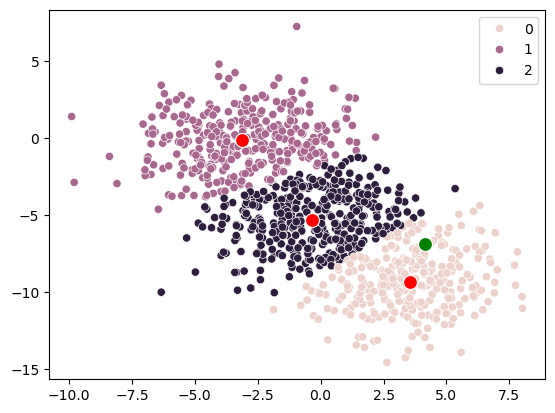

In [49]:
X, _ = make_blobs(centers=3, cluster_std=2, n_features=2, n_samples=1000)
# X = StandardScaler().fit_transform(X)
# normalize to max 1 dist
# X = X / np.max(pdist(X))
km = KMeans(n_clusters=3)
y = km.fit_predict(X)
C = km.cluster_centers_

# random point from X:
random_point = X[[np.random.randint(0, X.shape[0])]]


def plot(X, y, C, x, pca=False):
    if pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        x = pca.transform(x)
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='red', s=100, marker='o')
    sns.scatterplot(x=x[:, 0], y=x[:, 1], color='green', s=100, marker='o')
    plt.show()

plot(X, y, C, random_point, pca=False)

In [ ]:
class Loser:
    def __init__(self, C, X, target, x):
        """
        Parameters
        ----------
        C: cluster centers

        X: data

        target: target cluster label

        x: instance to be explained
        """
        self.C = C
        self.X = X
        self.target = target
        self.x = x

        self.max_t, self.min_t = self._find_cluster_distances()
        self.instance_cluster = self._classify(x)[0]
        self.y = self._classify(X)
        self.x_idx = np.where(np.all(X == x, axis=1))[0][0]

        feature_mins = X.min(axis=0)
        feature_maxs = X.max(axis=0)
        self.feature_ranges = feature_maxs - feature_mins

        self.loss_weights = {
            # self.yloss: 1,
            # self.gower_loss: 1,
            self.sigmoid_hinge_loss: 1,
            # self.is_valid: 1,
            self.sim_loss: 1,
            self.sparsity_loss: 1
            # self.baycon_loss: 1,
            # self.binary_hinge_loss: 1,
            # self.hinge_similarity_loss: 1,
        }

    def _classify(self, X):
        dists = np.linalg.norm(X[:, None] - self.C, axis=2)
        return np.argmin(dists, axis=1) 

    def _find_cluster_distances(self):
        c = self.C[[self.target]]
        dists = np.linalg.norm(self.X[y==self.target] - c, axis=1)
        return np.max(dists), np.min(dists)
    
    def yloss(self, cf):
        d = np.linalg.norm(cf - self.C[[self.target]])
        yloss = (d - self.min_t)/(self.max_t - self.min_t)
        return np.clip(yloss, 0, 1)
    
    def sim_loss(self, cf):
        d = np.linalg.norm(cf - self.x)
        d_sim = (d - self.min_t)/(self.max_t - self.min_t)
        return np.clip(d_sim, 0, 1)
    
    # def is_closer(self, cf):
    #     """Returns true if the given cf is closer to target center than original center"""
    #     return np.linalg.norm(cf - self.C[[self.instance_cluster]]) > np.linalg.norm(cf - self.C[[self.target]])
    
    # def binary_hinge_loss(self, cf):
    #     return int(not self.is_closer(cf))
    
    # def hinge_similarity_loss(self, cf):
    #     halfway = np.mean([self.C[[self.target]], self.C[[self.instance_cluster]]], axis=0)
    #     d = np.linalg.norm(cf - halfway)
    #     d_sim = d / np.linalg.norm(self.C[[self.target]] - halfway[:, None])

    #     return int(not self.is_closer(cf)) + d_sim - 1

    def is_valid(self, cf):
        cf_cluster = self._classify(cf)
        return (cf_cluster != self.target)[0]
    
    def sigmoid_hinge_loss(self, cf):
        d = np.linalg.norm(cf - self.C[[self.target]])
        off = self.max_t
        return 1 / (1 + np.exp(- (d - off)))
        
    def sparsity_loss(self, cf):
        return np.logical_not(np.isclose(cf, self.x, atol=0.1)).mean()

    def gower_loss(self, cf):
        diffs = np.abs(cf - self.x)
        scaled_diffs = diffs / self.feature_ranges
        sims = 1 - scaled_diffs
        return 1 - np.mean(sims)
    
    def baycon_loss(self, cf):
        return self.sim_loss(cf) * self.sparsity_loss(cf) * self.gower_loss(cf)
        
    def loss(self, cf):
        # l = sum([term(cf)*weight for term,weight in self.loss_weights.items()])
        l = math.prod([(term(cf)) for term in self.loss_weights.keys()])
        return l
    
l = Loser(C, X, 2, random_point)
print(l.loss(np.random.rand(1, 2)))

0.0


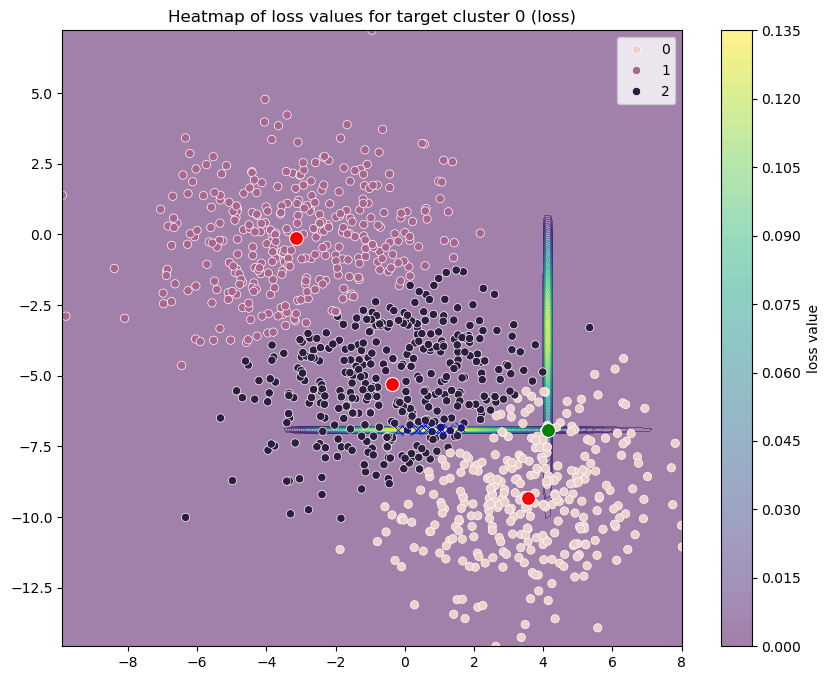

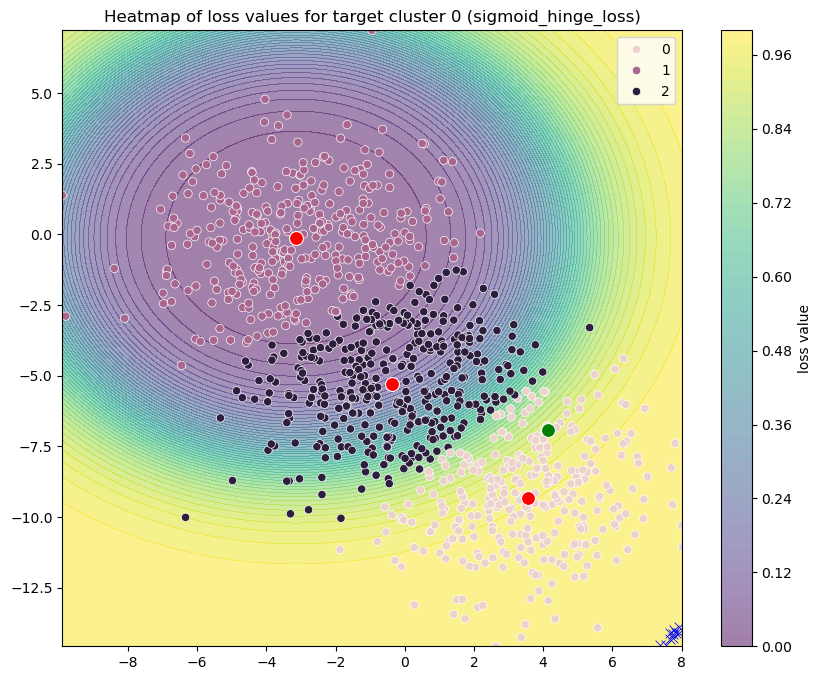

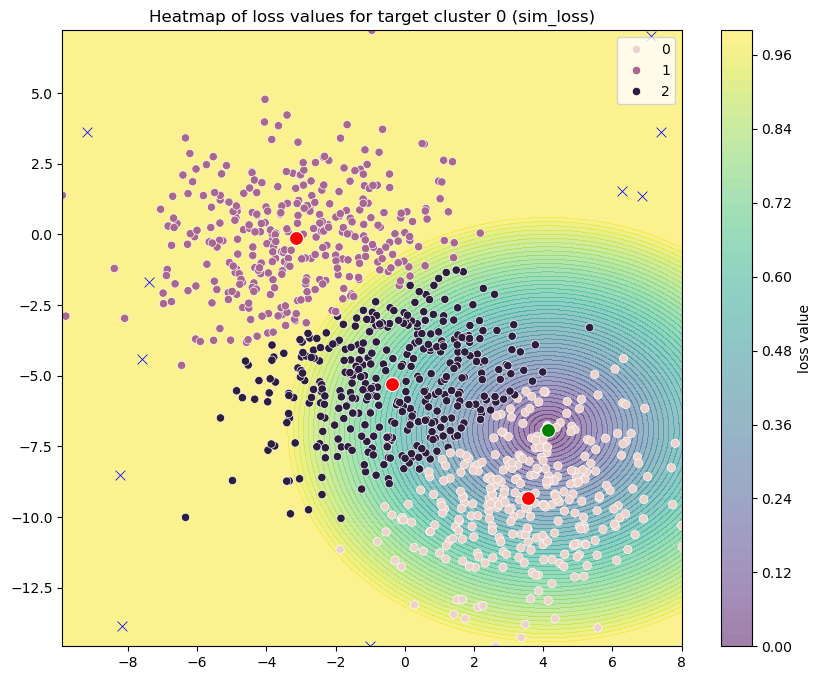

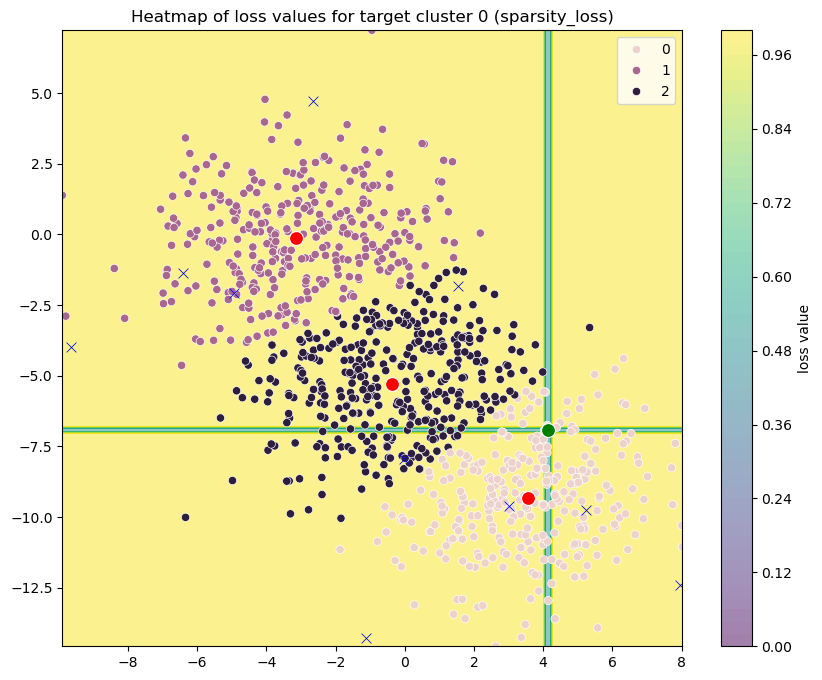

In [73]:
def plot_loss_heatmap(X, y, C, random_point, loss_fn, target_cluster, use_pca=False):

    oX, oC, oRP = [i.copy() for i in [X, C, random_point]]
    dim_ranges = np.abs(np.max(X, axis=0) - np.min(X, axis=0))
    samples = []
    for _ in range(10000):
        sample = np.random.rand(1, 2) * dim_ranges + np.min(X, axis=0)
        samples.append(sample)
    samples = np.array(samples).reshape(-1, 2)
    sample_losses = np.array([loss_fn(point.reshape(1, -1)) for point in samples])
    best_samples = samples[np.argsort(-sample_losses)[:10]]

    if use_pca:
        pca = PCA(n_components=2)
        X = pca.fit_transform(X)
        C = pca.transform(C)
        eS = pca.transform(samples)
        random_point = pca.transform(random_point)
    
    plt.figure(figsize=(10, 8))

    # Create a grid for the heatmap
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 250),
                         np.linspace(y_min, y_max, 250))
    grid_points = np.c_[xx.ravel(), yy.ravel()]
    yloss_values = np.array([loss_fn(point.reshape(1, -1)) for point in grid_points])
    yloss_grid = yloss_values.reshape(xx.shape)
    plt.contourf(xx, yy, yloss_grid, levels=50, cmap='viridis', alpha=0.5)
    plt.colorbar(label='loss value')


    # yloss_values = np.array([loss_fn(point.reshape(1, -1)) for point in samples])

    # Plot data points, cluster centers, and random point
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y)
    sns.scatterplot(x=C[:, 0], y=C[:, 1], color='red', s=100, marker='o')
    sns.scatterplot(x=random_point[:, 0], y=random_point[:, 1], color='green', s=100, marker='o')
    sns.scatterplot(x=best_samples[:, 0], y=best_samples[:, 1], color='blue', s=50, marker='x')

    plt.title(f'Heatmap of loss values for target cluster {target_cluster} ({loss_fn.__name__})')
    plt.show()

# Example usage
l = Loser(C, X, 1, random_point)
plot_loss_heatmap(X, y, C, random_point, l.loss, target_cluster=0, use_pca=False)
for lt in l.loss_weights.keys():
    plot_loss_heatmap(X, y, C, random_point, lt, target_cluster=0, use_pca=False)
